In [369]:
import numpy as np
import sympy
sympy.init_printing(use_unicode=True)
from sympy import symbols,simplify,diff,latex,Piecewise
from sympy.solvers import solve
from IPython.display import display
from typing import Callable
from sympy.utilities.lambdify import lambdify, implemented_function

%matplotlib inline
import matplotlib.pyplot as plt

def simplified(exp, title=None):
    simp = simplify(exp)
    if simplified.LOG:
        if title: display(title,simp)
        else: display(simp)
    return simp
simplified.LOG = True

def firstOrderCondition(exp, var):
    diffExp = simplified(diff(exp, var))
    solutions = solve(diffExp, var)
    if firstOrderCondition.LOG:
        display(solutions)
    return solutions
firstOrderCondition.LOG = True
  
class Result(object):   # a class for holding results of calculations
    def __repr__(self): return self.__dict__.__repr__()
    def display(self):
        for k,v in sorted(self.__dict__.items()):
            display(k,v)
    def subs(self, params):
        ans = Result()
        for k,v in sorted(self.__dict__.items()):
            if hasattr(v,"subs"):
                ans.__dict__[k] = v.subs(params)
            else:
                ans.__dict__[k] = v
        return ans

# Symbolic calculations

In [431]:
a,p,r,b,vmax,bmin,bmax,beta = symbols('a p r b v_{\max} b_{\min} b_{\max} \\beta', positive=True)
w,T,D,L,n,Supply = symbols('w T \\Delta L n \\tau', positive=True)
D,Supply

In [432]:
def exactCostPerDay(T):
    return (a*p + w*b*( (1+r)**T - 1 )) / T

def approxCostPerDay(T):
    return a*p/T + w*b*r

def symmetricLifetime(w):
    return w**2/4/L

def asymmetricLifetime(w):
    return w / D


uniformPDF = Piecewise( (1 / bmax , b<bmax), (0, True) )
powerlawPDF =  Piecewise( (0 , b<bmin), (bmin / b**2, True) )

display(sympy.integrate(uniformPDF, (b, 0, np.inf)))  # should be 1
display(sympy.integrate(powerlawPDF, (b, 0, np.inf))) # should be 1

In [433]:
params = {
    L: 10,           # total transfers per day 
    D: 6,            # delta transfers per day 
    beta: 0.01,      # value / transfer-size
    r: 4/100/365,    # interest rate per day
    a: 1.1,          # records per reset tx
    Supply: 288000,  # records per day
    bmin: 0.001,     # min transfer size (for power law distribution)
    bmax: 1,         # max transfer size (for uniform distribution)
}

In [512]:
def calculateMarketEquilibrium(costPerDay:Callable, channelLifetime:Callable, wSolutionIndex:int):
    T = simplified(channelLifetime(w), "T")
    CPD = simplified(costPerDay(T), "CPD")
    optimal = Result()
    optimal.w = simplified(firstOrderCondition(CPD,w)[wSolutionIndex], "Optimal channel funding (w)")
    optimal.T   = simplified(T.subs(w,optimal.w), "optimal channel lifetime (T)")
    optimal.CPD = simplified(CPD.subs(w,optimal.w), "Cost-per-day") 
    optimal.RPD = simplified(a / optimal.T, "Potential records per day") 
    optimal.C   =   simplified(optimal.CPD*optimal.T, "Cost between resets") 
    optimal.V   =   simplified(optimal.T*L*beta*b, "Value between resets")
    optimal.VCR1 = 1
    optimal.VCR2 = simplified(optimal.V / optimal.C, "Value/Cost Ratio of lightning")
    optimal.VCR3 = simplified(beta*b / p, "Value/Cost Ratio of blockchain")
    optimal.b12  = simplified(solve(optimal.VCR1-optimal.VCR2,b)[0],"b below which an agent prefers nop to lightning")
    optimal.b13  = simplified(solve(optimal.VCR1-optimal.VCR3,b)[0],"b below which an agent prefers nop to blockchain")
    optimal.b23  = simplified(solve(optimal.VCR2-optimal.VCR3,b)[0],"b below which an agent prefers lightning to blockchain")

    # Calculate threshold prices. This part is relevant only for uniform valuations.
    optimal.p12 = simplified(solve(optimal.b12-bmax,p)[0],"price above which all agents prefer nop to lightning")
    optimal.p13 = simplified(solve(optimal.b13-bmax,p)[0],"price above which all agents prefer nop to blockchain")
    optimal.p23 = simplified(solve(optimal.b23-bmax,p)[0],"price above which all agents prefer lightning to blockchain")

    
    # substitute the numeric params:
    numeric = optimal.subs(params)
    numeric.b23 = numeric.b23.evalf()
    numeric.p23 = numeric.p23.evalf()
    return (optimal,numeric)

In [506]:
simplified.LOG = False
firstOrderCondition.LOG = False
(asymmetricSymbolic,asymmetricNumeric) = calculateMarketEquilibrium(approxCostPerDay,asymmetricLifetime,wSolutionIndex=0)

'C'

'CPD'

'RPD'

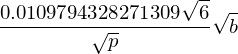

'T'

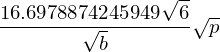

'V'

'VCR1'

'VCR2'

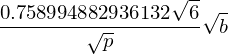

'VCR3'

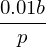

'b12'

'b13'

'b23'

'p12'

'p13'

'p23'

'w'

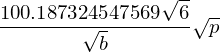

In [507]:
#asymmetricSymbolic.display()
asymmetricNumeric.display()

In [518]:
simplified.LOG = False
firstOrderCondition.LOG = False
(symmetricSymbolic,symmetricNumeric) = calculateMarketEquilibrium(approxCostPerDay,symmetricLifetime,wSolutionIndex=0)

'C'

'CPD'

'RPD'

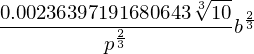

'T'

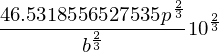

'V'

'VCR1'

'VCR2'

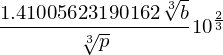

'VCR3'

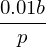

'b12'

'b13'

'b23'

'p12'

'p13'

'p23'

'w'

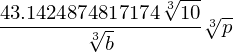

In [519]:
symmetricNumeric.display()

# Demand curves

'demand without lightning'

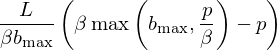

'demand with lightning'

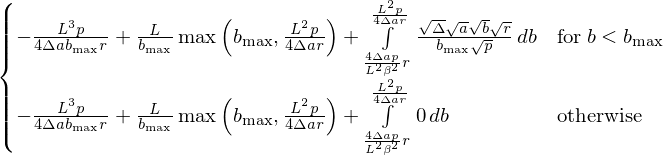

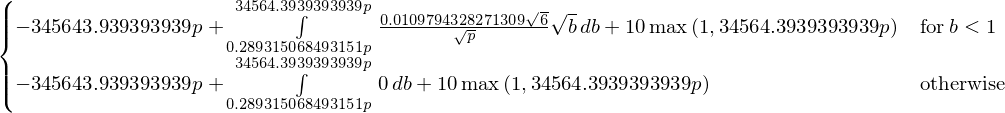

In [531]:
### Generic function for calculating demand - does not give plottable expressions:

def calculateDemands(optimal, valuePDF):
    optimal.demandWithoutLightning = simplified(
        sympy.integrate(L * valuePDF,             (b, optimal.b13,np.inf)),
        "demand without lightning"
    )
    optimal.demandWithLightning = simplified(
        sympy.integrate(a / optimal.T * valuePDF, (b, optimal.b12,optimal.b23)) +\
        sympy.integrate(L * valuePDF,             (b, optimal.b23,np.inf)),
        "demand with lightning"
    )
    return optimal

simplified.LOG = True
calculateDemands(asymmetricSymbolic, uniformPDF)
asymmetricNumeric = asymmetricSymbolic.subs(params)
display(asymmetricNumeric.demandWithoutLightning)
display(asymmetricNumeric.demandWithLightning)

# Plots

In [532]:
def plotSymbolic(xRange, yExpression, xVariable, style, label):
    plt.plot(xRange, [yExpression.subs(xVariable,xValue) for xValue in xRange], style, label=label)
    
def plotDemandCurves(priceRange, demandWithoutLightning, demandAsymmetric, demandSymmetric):
    plotSymbolic(priceRange, demandWithoutLightning, p, "r-",label="no lightning")
    plotSymbolic(priceRange, demandAsymmetric, p,  "b.",label="asymmetric")
    plotSymbolic(priceRange, demandSymmetric, p,  "g--",label="symmetric")
    plt.gca().set_ylim(-1,11)
    plt.xlabel("blockchain fee $p$  [coins]")
    plt.ylabel("Demand of a single pair [records/day]")
    plt.legend()

    
def plotPriceCurves(nRange, priceWithoutLightning, priceAsymmetric, priceSymmetric):
    plotSymbolic(nRange, priceWithoutLightning, n, "r-",label="no lightning")
    plotSymbolic(nRange, priceAsymmetric, n,  "b.",label="asymmetric")
    if priceSymmetric:
        plotSymbolic(nRange, priceSymmetric, n,  "g--",label="symmetric")
    #plt.gca().set_ylim(-1,11)
    plt.xlabel("Number of pairs")
    plt.ylabel("Market-equilibrium price [coins/record]")
    plt.legend()

## Uniform distribution

'demand without lightning'

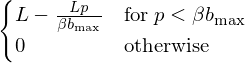

'demand with lightning'

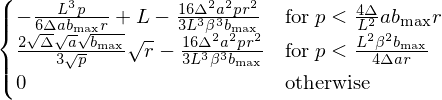

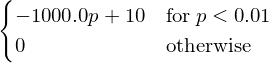

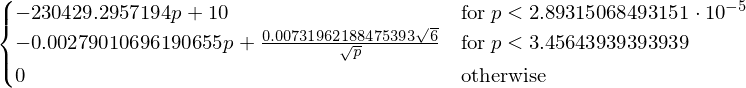

'demand without lightning'

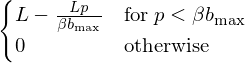

'demand with lightning'

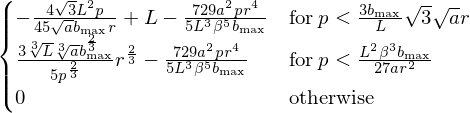

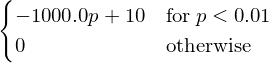

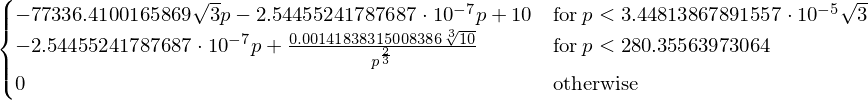

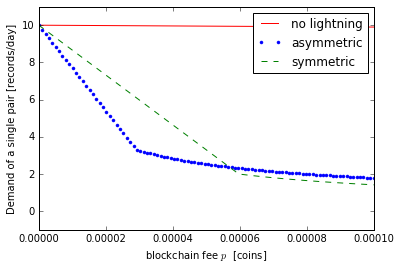

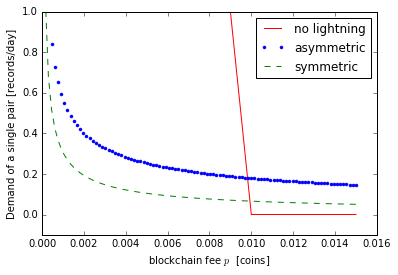

In [530]:
def calculateDemandsUniformDistribution(optimal):
    optimal.demandB13 = sympy.integrate(L / bmax,             (b, optimal.b13, bmax))
    optimal.demandWithoutLightning = simplified(Piecewise(
        (optimal.demandB13, p < optimal.p13),    # b13 < bmax
        (0, True)),
        "demand without lightning"
    )
    optimal.demandL1 = sympy.integrate(a / optimal.T / bmax, (b, optimal.b12, optimal.b23)) # b12<b23<bmax
    optimal.demandL2 = sympy.integrate(a / optimal.T / bmax, (b, optimal.b12, bmax))        # b12<bmax<b23
    optimal.demandB23  = sympy.integrate(L / bmax,         (b, optimal.b23, bmax))          # b23<bmax
    optimal.demandWithLightning = simplified(Piecewise(
        (optimal.demandL1+optimal.demandB23 , p < optimal.p23),   # b23 < bmax
        (optimal.demandL2 , p < optimal.p12),   # b12 < bmax
        (0, True)),
        "demand with lightning"
    )

simplified.LOG = True

calculateDemandsUniformDistribution(asymmetricSymbolic)
asymmetricNumeric = asymmetricSymbolic.subs(params)
display(asymmetricNumeric.demandWithoutLightning)
display(asymmetricNumeric.demandWithLightning)

calculateDemandsUniformDistribution(symmetricSymbolic)
symmetricNumeric = symmetricSymbolic.subs(params)
display(symmetricNumeric.demandWithoutLightning)
display(symmetricNumeric.demandWithLightning)

#plot:
priceRange = np.linspace(0,1e-4,100)
plotDemandCurves(priceRange, asymmetricNumeric.demandWithoutLightning, asymmetricNumeric.demandWithLightning, symmetricNumeric.demandWithLightning)
plt.savefig('../graphs/demand-curves-small-price.pdf', format='pdf', dpi=1000)    
plt.show()

priceRange = np.linspace(0,0.015,100)
plotDemandCurves(priceRange, asymmetricNumeric.demandWithoutLightning, asymmetricNumeric.demandWithLightning, symmetricNumeric.demandWithLightning)
plt.gca().set_ylim(-0.1,1)
plt.savefig('../graphs/demand-curves-large-price.pdf', format='pdf', dpi=1000)    
plt.show()

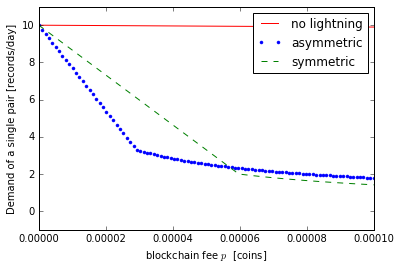

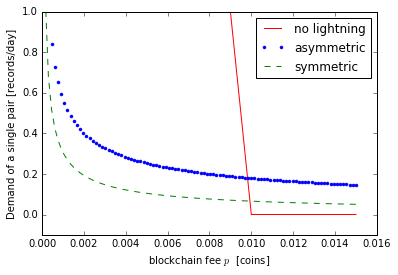

In [500]:
simplified.LOG = True

### Demand curves

#asymmetric case:
(b12,b13,b23) = (asymmetricNumeric.b12,asymmetricNumeric.b13,asymmetricNumeric.b23)
(p12,p13,p23) = (asymmetricNumeric.p12,asymmetricNumeric.p13,asymmetricNumeric.p23)
demand1 = (2/3 * sympy.sqrt(D*a*r/p/bmax**2)*(b23**(3/2) - b12**(3/2)) + L*(bmax-b23)).subs(params)
demand2 = (2/3 * sympy.sqrt(D*a*r/p/bmax**2)*(bmax**(3/2) - b12**(3/2))).subs(params)
asymmetricNumeric.demandWithLightning = Piecewise(
    (demand1 , p < p23), 
    (demand2 , p < p12),
    (0, True))

#symmetric case:
(b12s,b13s,b23s) = (symmetricNumeric.b12,symmetricNumeric.b13,symmetricNumeric.b23)
(p12s,p13s,p23s) = (symmetricNumeric.p12,symmetricNumeric.p13,symmetricNumeric.p23)
demand1s = (3/5 * (L*a*r**2/p**2/bmax**3)**(1/3)*(b23s**(5/3) - b12s**(5/3)) + L*(bmax-b23s)).subs(params)
demand2s = (3/5 * (L*a*r**2/p**2/bmax**3)**(1/3)*(bmax**(5/3) - b12s**(5/3))).subs(params)
symmetricNumeric.demandWithLightning = Piecewise(
    (demand1s , p < p23s),
    (demand2s , p < p12s),
    (0, True))

#plot:
priceRange = np.linspace(0,1e-4,100)
plotDemandCurves(priceRange, asymmetricNumeric.demandWithoutLightning, asymmetricNumeric.demandWithLightning, symmetricNumeric.demandWithLightning)
plt.savefig('../graphs/demand-curves-small-price.pdf', format='pdf', dpi=1000)    
plt.show()

priceRange = np.linspace(0,0.015,100)
plotDemandCurves(priceRange, asymmetricNumeric.demandWithoutLightning, asymmetricNumeric.demandWithLightning, symmetricNumeric.demandWithLightning)
plt.gca().set_ylim(-0.1,1)
plt.savefig('../graphs/demand-curves-large-price.pdf', format='pdf', dpi=1000)    
plt.show()

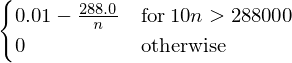

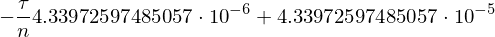

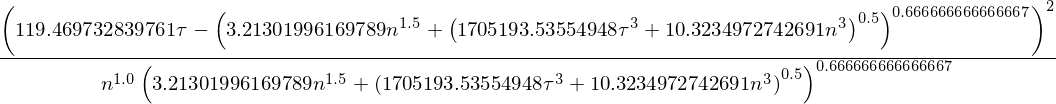

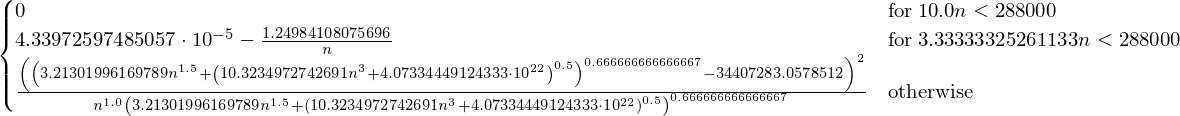

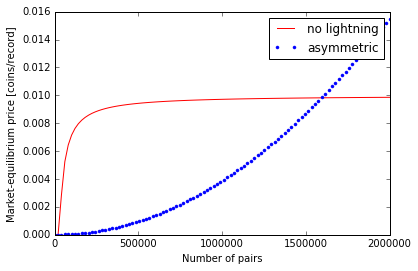

In [496]:
### Price curves
simplified.LOG = True

max_demand = params[L]
min_demand = asymmetricNumeric.demandWithLightning.subs(p,p13).evalf(); 

priceWithoutLightning = simplified(Piecewise(
    (beta*bmax*(1-Supply/n/L) , n*L>Supply),
    (0,True)).subs(params))


price1 = simplified(solve(n*demand1-Supply, p)[0])
price2 = simplified(solve(n*demand2-Supply, p)[0])

max_demand1 = demand1.subs(p,0).evalf();
min_demand1 = demand1.subs(p,p23).evalf(); 
max_demand2 = demand2.subs(p,p23).evalf(); 
min_demand2 = demand2.subs(p,p12).evalf();

asymmetricNumeric.priceWithLightning = simplified(Piecewise(
    (0, Supply > n*max_demand1),
    (price1 , Supply > n*min_demand1), 
    (price2 , Supply > n*min_demand2),
    (0, True)).subs(params))

#price1s = simplified(solve(n*demand1s-Supply, p)[0])
# price2s = simplified(solve(n*demand2s-Supply, p)[0])  # unsolvable

max_demand1s = demand1s.subs(p,0).evalf();
min_demand1s = demand1s.subs(p,p23s).evalf(); 
max_demand2s = demand2s.subs(p,p23s).evalf(); 
min_demand2s = demand2s.subs(p,p12s).evalf();

symmetricNumeric.priceWithLightning = None
#symmetricNumeric.priceWithLightning = simplified(Piecewise(
#    (0, Supply > n*max_demand1s),
#    (price1s , Supply > n*min_demand1s), 
#    price2s, Supply > n*min_demand2s),   # u
#    (0, True)).subs(params))



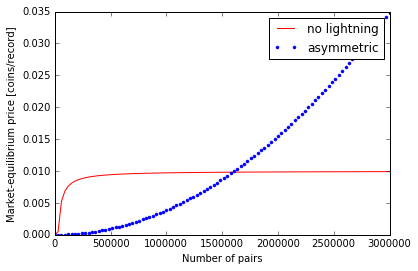

In [499]:
nRange = np.linspace(0,3000000,100)
plotPriceCurves(nRange, priceWithoutLightning, asymmetricNumeric.priceWithLightning, symmetricNumeric.priceWithLightning)
plt.savefig('../graphs/price-curves.pdf', format='pdf', dpi=1000)